In [1]:
!mkdir models

# Классификация Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [ ]:
# Получаем датасет
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

# Библиотеки

In [ ]:
# === Системные и основные утилиты ===
import os
import io

# === Научные вычисления и работа с данными ===
import numpy as np
import pandas as pd

# === Визуализация данных ===
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# === Машинное обучение и метрики ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score

# === Глубокое обучение (TensorFlow/Keras) ===
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Инструменты мониторинга обучения ===
from livelossplot.inputs.keras import PlotLossesCallback

# === Проверка аппаратного обеспечения ===
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


## EDA

(92, 86)


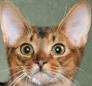

In [ ]:
# 1. Загрузка и первичный осмотр изображения
image = Image.open("petfaces/cat_Abyssinian/Abyssinian_1.jpg")

# Выводим исходный размер изображения (проверка размерности данных)
print(image.size)

image

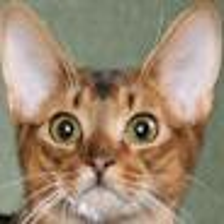

In [ ]:
# 2. Предварительная обработка изображения
# Изменяем размер изображения до стандартного (224x224)
image = image.resize((224,224))

image

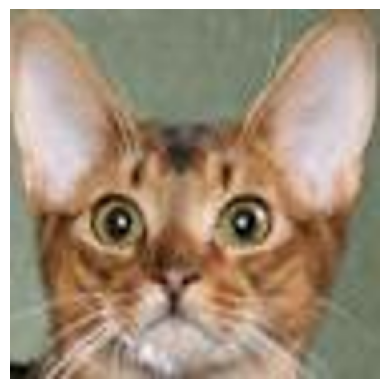

In [ ]:
# 3. Преобразование в массив и визуализация
# Конвертируем изображение в numpy array для численного анализа
im = np.array(image)

plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# 4. Нормализация данных
# Преобразуем изображение в 1D вектор и нормализуем значения пикселей в диапазон [0, 1]
image = np.array(image).flatten() / 255
image

array([0.55294118, 0.53333333, 0.41568627, ..., 0.45882353, 0.49411765,
       0.41176471])

# Нейройронная сеть для бинарной классификации

In [ ]:
# Пути к данным и новая директория для классификации
train_path         = "petfaces"
new_folder_classes = "petfaces_classes"

# Создание папки для бинарной классификации (кошки/собаки)
try:
    os.mkdir(new_folder_classes)
except:
    print(f"Папка '{new_folder_classes}' уже существует")  

# Создание подпапок для каждого класса
for i in ['cat', 'dog']:
    try:
        os.mkdir(f"./{new_folder_classes}/{i}")
    except:
        print(f"Папка '{i}' уже существует")

Folder 'petfaces_classes' already exists


In [ ]:
# Распределение изображений по классам (cat/dog)
for folder in os.listdir(train_path):
    # Пропускаем скрытые файлы
    if folder.startswith("."):
        continue
    
    # Обработка каждого файла в папке
    for file in os.listdir(os.path.join(train_path, folder)):
        # Копируем изображения кошек
        if folder.startswith('cat'):
            try:
                Image.open(os.path.join(train_path, folder, file)).save(f"{new_folder_classes}/cat/{file}")
            except:
                print(f"Ошибка обработки файла: {file} (возможно, битый)")
        # Копируем изображения собак
        elif folder.startswith('dog'):
            try:
                Image.open(os.path.join(train_path, folder, file)).save(f"{new_folder_classes}/dog/{file}")
            except:
                print(f"Ошибка обработки файла: {file} (возможно, битый)")

In [ ]:
# Константы
PATH: str = "petfaces_classes"
VALIDATION_SPLIT: float = 0.2
RANDOM_SEED: int = 906
IMAGE_SIZE: tuple = (224, 224)
BATCH_SIZE: int = 16


def create_dataset(
    directory: str,
    subset: str,
    validation_split: float,
    seed: int,
    image_size: tuple,
    batch_size: int
) -> tf.data.Dataset:
    """
    Description:
    ---------------
        Создает tf.data.Dataset из изображений в указанной директории.

    Args:
    ---------------
        directory: Путь к директории с изображениями
        subset: Тип набора данных ('training' или 'validation')
        validation_split: Доля данных для валидации
        seed: Seed для воспроизводимости
        image_size: Размер изображений (height, width)
        batch_size: Размер батча

    Returns:
    ---------------
        tf.data.Dataset с изображениями и метками

    Raises:
    ---------------
        ValueError: Если указан неверный subset
    """
    return tf.keras.utils.image_dataset_from_directory(
        directory=directory,
        validation_split=validation_split,
        subset=subset,
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
    )


def extract_features_and_labels(dataset: tf.data.Dataset) -> tuple:
    """
    Description:
    ---------------
        Извлекает признаки и метки из tf.data.Dataset.

    Args:
    ---------------
        dataset: Набор данных для обработки

    Returns:
    ---------------
        Кортеж (features, labels) в виде numpy массивов
    """
    features, labels = [], []
    for images, label in dataset:
        features.extend(images.numpy())
        labels.extend(label.numpy())
    return np.array(features), np.array(labels)

In [ ]:
# Создание train и validation datasets
train_ds = create_dataset(
    directory=PATH,
    subset="training",
    validation_split=VALIDATION_SPLIT,
    seed=RANDOM_SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = create_dataset(
    directory=PATH,
    subset="validation",
    validation_split=VALIDATION_SPLIT,
    seed=RANDOM_SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Получение имен классов
class_names = train_ds.class_names
print("Class names:", class_names)

# Извлечение признаков и меток
X_train, y_train = extract_features_and_labels(train_ds)
X_test,  y_test = extract_features_and_labels(val_ds)

# Проверка размерности данных
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:",  X_test.shape)
print("Shape of y_test:",  y_test.shape)

Found 3211 files belonging to 2 classes.
Using 2569 files for training.
Found 3211 files belonging to 2 classes.
Using 642 files for validation.
['cat', 'dog']
2025-04-08 14:47:49.773666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Shape of X_train: (2569, 224, 224, 3)
Shape of y_train: (2569,)
Shape of X_test: (642, 224, 224, 3)
Shape of y_test: (642,)
2025-04-08 14:47:50.819016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Порода: cat


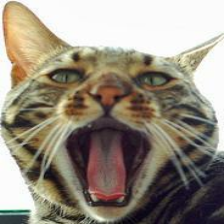

In [ ]:
num = 121                                                # Рандомный номер
print(f"Порода: {train_ds.class_names[y_train[num]]}")   # Выведем породу
tf.keras.utils.array_to_img(X_train[num]) # Выведем изображение животного

In [ ]:
# Определение количества классов
num_classes: int = len(val_ds.class_names)


def create_sequential_model(input_shape: tuple, num_classes: int) -> tf.keras.Sequential:
    """
    Description:
    ---------------
        Создает последовательную модель CNN для классификации изображений.

    Args:
    ---------------
        input_shape: Форма входных данных (height, width, channels)
        num_classes: Количество классов для классификации

    Returns:
    ---------------
        tf.keras.Sequential: Скомпилированная модель CNN

    Architecture:
    ---------------
        - 3 блока Conv2D + MaxPooling2D
        - Полносвязные слои с BatchNormalization и Dropout
        - Выходной слой с активацией softmax
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # Нормализацию можно добавить через Rescaling(1./255)
        
        # Первый блок свертки
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Второй блок свертки
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Третий блок свертки
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Полносвязные слои
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        
        # Выходной слой
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


def compile_model(model: tf.keras.Sequential) -> None:
    """
    Description:
    ---------------
        Компилирует модель с заданными параметрами оптимизации.

    Args:
    ---------------
        model: Модель для компиляции

    Configuration:
    ---------------
        - Оптимизатор: Adam с learning_rate=2e-4
        - Функция потерь: SparseCategoricalCrossentropy
        - Метрика: accuracy
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )


# Создание и компиляция модели
model = create_sequential_model(
    input_shape=X_train[0].shape,
    num_classes=num_classes
)

compile_model(model)

# Вывод информации о модели
model.summary(show_trainable=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d_3 (Conv2D)           │ (None, 222, 222, 32)  │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_3             │ (None, 111, 111, 32)  │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_4 (Conv2D)           │ (None, 109, 109, 32)  │      9,248 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_4             │ (None, 54, 54, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_5 (Conv2D)           │ (None, 52, 52, 32)    │      9,248 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_5             │ (None, 26, 26, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 21632)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │  2,769,024 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_1       │ (None, 128)           │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 64)            │      8,256 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_6 (Dense)             │ (None, 32)            │      2,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 32)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_7 (Dense)             │ (None, 2)             │         66 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,799,330 (10.68 MB)

 Trainable params: 2,799,074 (10.68 MB)

 Non-trainable params: 256 (1.00 KB)

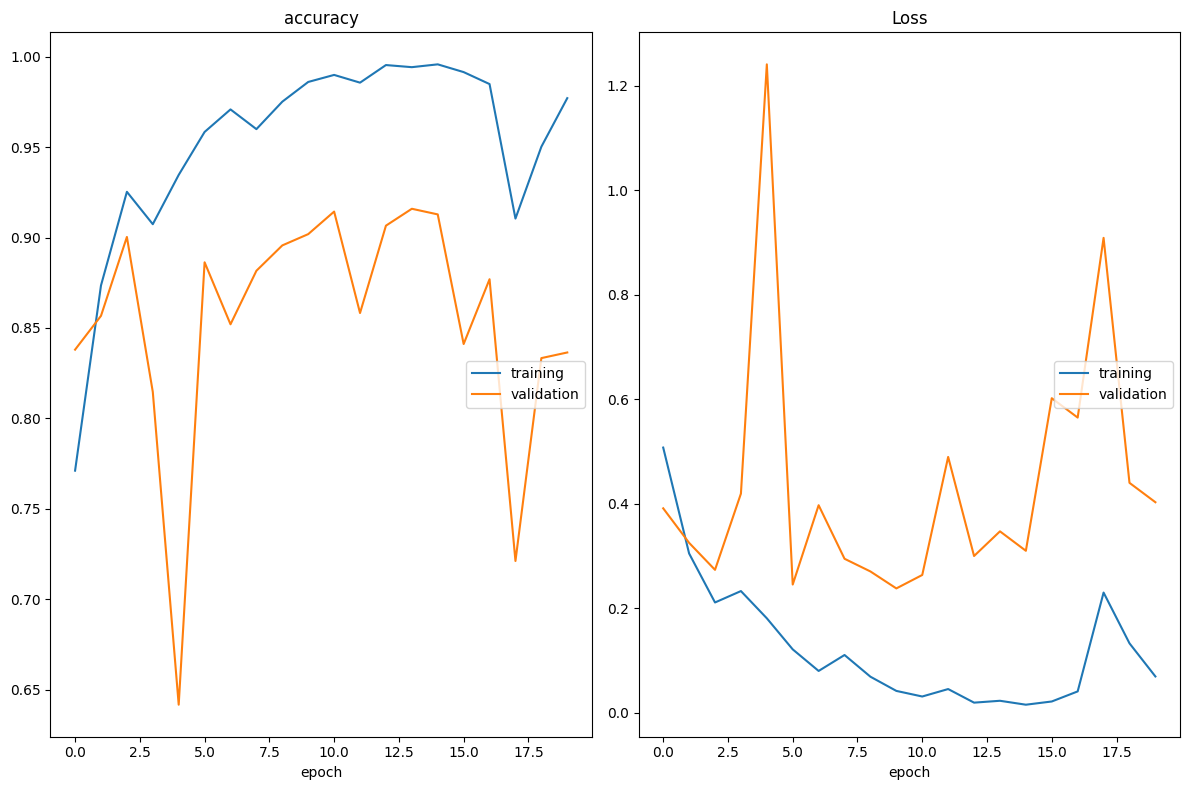

accuracy
	training         	 (min:    0.771, max:    0.996, cur:    0.977)
	validation       	 (min:    0.642, max:    0.916, cur:    0.836)
Loss
	training         	 (min:    0.016, max:    0.508, cur:    0.070)
	validation       	 (min:    0.238, max:    1.241, cur:    0.403)
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9855 - loss: 0.0520 - val_accuracy: 0.8364 - val_loss: 0.4030


In [ ]:
# Callback для визуализации процесса обучения
plot_loss = PlotLossesCallback()

# Callback для ранней остановки обучения
early_stopping = EarlyStopping(
    monitor='val_loss',         # Мониторим потери на валидации
    patience=10,                # Количество эпох без улучшений перед остановкой
    restore_best_weights=True,  # Восстанавливаем веса лучшей модели
    mode='min'                  # Ожидаем уменьшения метрики
)

# Обучение модели
hist = model.fit(
    X_train,                           # Обучающие данные
    y_train,                           # Обучающие метки
    validation_data=(X_test, y_test),  # Данные для валидации
    epochs=50,                         # Максимальное количество эпох
    batch_size=16,                     # Размер батча
    verbose=1,                         # Уровень детализации вывода (1 - с прогрессбаром)
    callbacks=[
        early_stopping,                # Ранняя остановка при переобучении
        plot_loss                      # Визуализация потерь в реальном времени
    ]
)

In [ ]:
# Получение предсказаний модели на тестовых данных
# Возвращает матрицу вероятностей для каждого класса (формат [num_samples, num_classes])
predicted_classes = model.predict(X_test)

# Преобразование вероятностей в предсказанные классы:
# - np.argmax выбирает индекс максимального значения (номер класса)
# - axis=1 означает поиск максимума по строкам (для каждого примера отдельно)
predicted_classes = np.argmax(predicted_classes, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


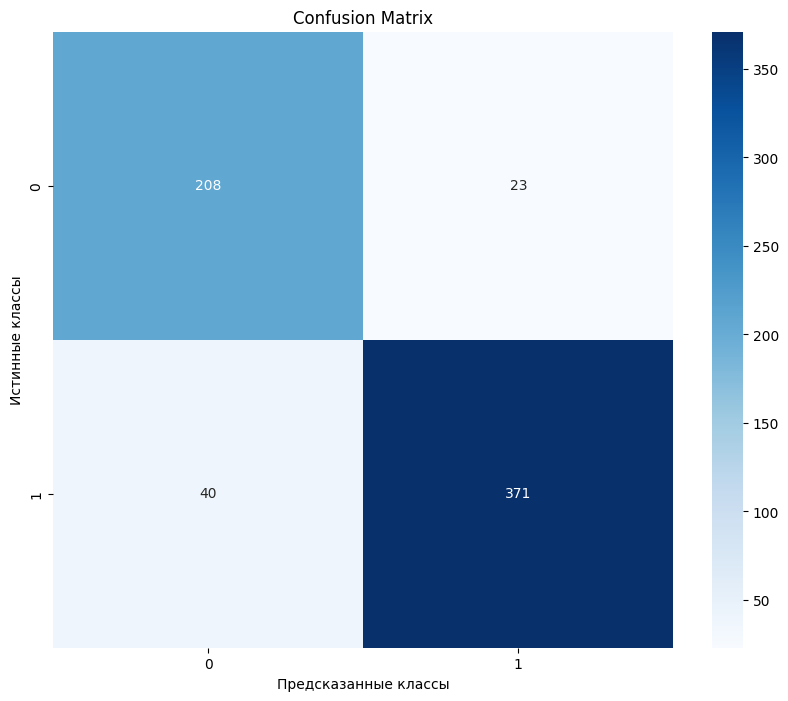

Accuracy VGG-16: 0.90


In [ ]:
cm = confusion_matrix(y_test, predicted_classes)

# Отображение confusion matrix с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {accuracy_score(y_test, predicted_classes):.2f}")

In [ ]:
# Иной способ провести оценку качества полученной модели
eval_metrics = model.evaluate(X_test, y_test)
print(f"Logloss: {eval_metrics[0]}")
print(f"Accuracy: {eval_metrics[1]}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8938 - loss: 0.2430
Logloss: 0.23815207183361053
Accuracy: 0.9018691778182983


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
Порода:
dog # 1

Предсказанная порода моделью:
dog # 1


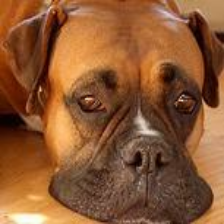

In [ ]:
num = 42                                                             # Рандомный номер
predicted_breed = model.predict(np.expand_dims(X_test[num], axis=0)) # Предсказываем моделью вероятности
predicted_breed = np.argmax(predicted_breed)                         # Вытаскиваем наиболее вероятный класс

print(f"Порода:\n{class_names[y_test[num]]} # {y_test[num]}")                                 # Выведем истинный класс
print(f"\nПредсказанная порода моделью:\n{class_names[predicted_breed]} # {predicted_breed}") # Выведем предсказанный класс
tf.keras.utils.array_to_img(X_test[num])                                                      # Выведем изображение животного

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Порода:
cat # 0

Предсказанная порода моделью:
cat # 0


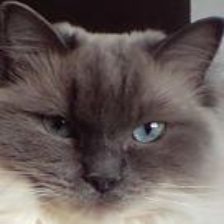

In [ ]:
num = 1024                                                           # Рандомный номер
predicted_breed = model.predict(np.expand_dims(X_test[num], axis=0)) # Предсказываем моделью вероятности
predicted_breed = np.argmax(predicted_breed)                         # Вытаскиваем наиболее вероятный класс

print(f"Порода:\n{class_names[y_test[num]]} # {y_test[num]}")                                 # Выведем истинный класс
print(f"\nПредсказанная порода моделью:\n{class_names[predicted_breed]} # {predicted_breed}") # Выведем предсказанный класс
tf.keras.utils.array_to_img(X_test[num])                                                      # Выведем изображение животного

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: cat


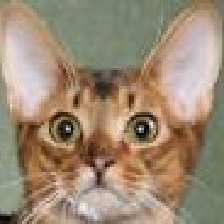

In [ ]:
# Путь к тестовому изображению
img_path = "petfaces/cat_Abyssinian/Abyssinian_1.jpg"

# Загрузка и подготовка изображения
img = image.load_img(img_path, target_size=(224, 224))   # Загрузка с ресайзом
img_array = image.img_to_array(img)                      # Конвертация в numpy-массив
img_array = np.expand_dims(img_array, axis=0)            # Добавление batch-размерности

# Получение и обработка предсказания
predicted_breed = model.predict(img_array)               # Получение вероятностей классов
predicted_breed = np.argmax(predicted_breed)             # Выбор класса с максимальной вероятностью

# Вывод результата
print("Predicted class:", class_names[predicted_breed])  # Вывод названия класса
img                                                      # Отображение изображения

# Нейросеть для многоклассовой классификации

In [ ]:
# Путь к директории с изображениями
PATH = "petfaces"

# Создание тренировочного набора данных:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PATH,
    validation_split=0.2,
    subset='training',
    seed=906,
    image_size=(224, 224),
    batch_size=16
)

# Создание валидационного набора данных (аналогично тренировочному, но subset='validation')
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PATH,
    validation_split=0.2,
    subset='validation',
    seed=906,
    image_size=(224, 224),
    batch_size=16
)

# Получение списка имен классов из тренировочного набора
class_names = train_ds.class_names

# Вывод списка классов для проверки
print("Available classes:", class_names)

2025-04-08 14:54:31.231940: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-08 14:54:31.231968: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-08 14:54:31.231975: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-08 14:54:31.231992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-08 14:54:31.232007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Разбивка на train/test
X_train, y_train = [], []
for images, labels in train_ds:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test, y_test = [], []
for images, labels in val_ds:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

# Проверка размерности данных
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2569, 224, 224, 3)
Shape of y_train: (2569,)
Shape of X_test: (642, 224, 224, 3)
Shape of y_test: (642,)


Выведем пример одного изображения из обучающего набора данных

Порода: cat_Bengal


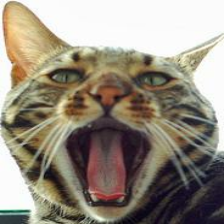

In [ ]:
num = 129                                                # Рандомный номер
print(f"Порода: {train_ds.class_names[y_train[num]]}")   # Выведем породу
tf.keras.utils.array_to_img(X_train[num])                # Выведем изображение животного

In [ ]:
# Определение количества классов на основе валидационного набора данных
num_classes = len(val_ds.class_names)

# Создание последовательной модели нейронной сети
model = tf.keras.Sequential([
    # Входной слой с формой, соответствующей форме входных данных
    tf.keras.layers.Input(shape=X_train[0].shape),
    
    # Блок сверточных слоев с пуллингом для извлечения признаков
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Преобразование многомерных данных в одномерные
    tf.keras.layers.Flatten(),
    
    # Полносвязные слои для классификации
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    
    # Слой dropout для регуляризации и предотвращения переобучения
    tf.keras.layers.Dropout(0.2),
    
    # Выходной слой с активацией softmax для многоклассовой классификации
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Компиляция модели с указанием оптимизатора, функции потерь и метрик
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=2e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Вывод информации о модели с отображением обучаемых параметров
model.summary(show_trainable=True)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d_18 (Conv2D)          │ (None, 222, 222, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_18            │ (None, 111, 111, 64)  │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_19 (Conv2D)          │ (None, 109, 109, 32)  │     18,464 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_19            │ (None, 54, 54, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_20 (Conv2D)          │ (None, 52, 52, 32)    │      9,248 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_20            │ (None, 26, 26, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_21 (Conv2D)          │ (None, 24, 24, 32)    │      9,248 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_21            │ (None, 12, 12, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_6 (Flatten)         │ (None, 4608)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_23 (Dense)            │ (None, 512)           │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_24 (Dense)            │ (None, 512)           │    262,656 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_6 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_25 (Dense)            │ (None, 35)            │     17,955 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,679,171 (10.22 MB)

 Trainable params: 2,679,171 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

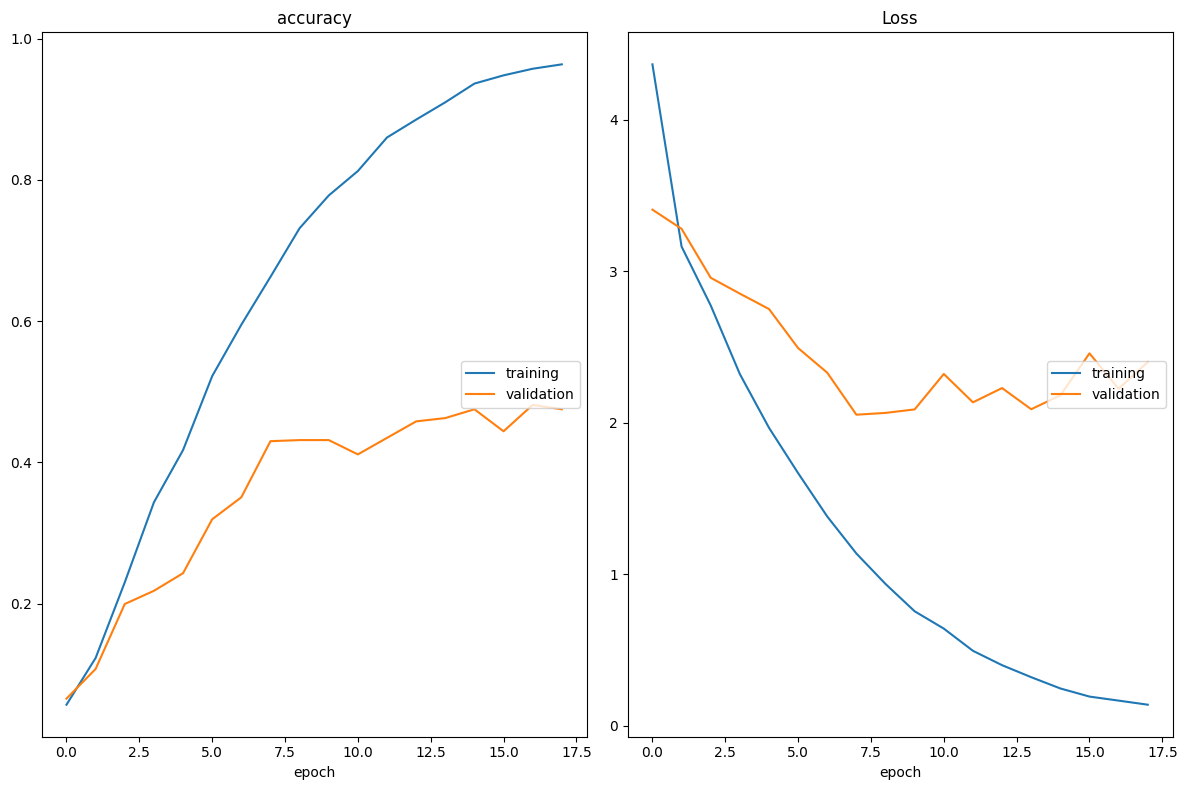

accuracy
	training         	 (min:    0.057, max:    0.963, cur:    0.963)
	validation       	 (min:    0.065, max:    0.481, cur:    0.475)
Loss
	training         	 (min:    0.140, max:    4.365, cur:    0.140)
	validation       	 (min:    2.053, max:    3.406, cur:    2.401)
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9685 - loss: 0.1317 - val_accuracy: 0.4751 - val_loss: 2.4008


In [ ]:
# Инициализация callback'а для отображения графиков потерь во время обучения
plot_loss = PlotLossesCallback()

# Настройка ранней остановки обучения:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Мониторим validation loss
    patience=10,                # Количество эпох без улучшения перед остановкой
    restore_best_weights=True,  # Возвращаем веса лучшей модели
    mode='min'                  # Режим минимизации метрики
)

# Обучение модели с использованием:
hist = model.fit(
    X_train,                               # Обучающие данные
    y_train,                               # Обучающие метки
    validation_data=(X_test, y_test),      # Данные для валидации
    epochs=100,                            # Максимальное количество эпох
    batch_size=32,                         # Размер батча
    verbose=1,                             # Уровень детализации вывода (1 - с прогрессбаром)
    callbacks=[early_stopping, plot_loss]  # Используемые callback'ы
)

In [18]:
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


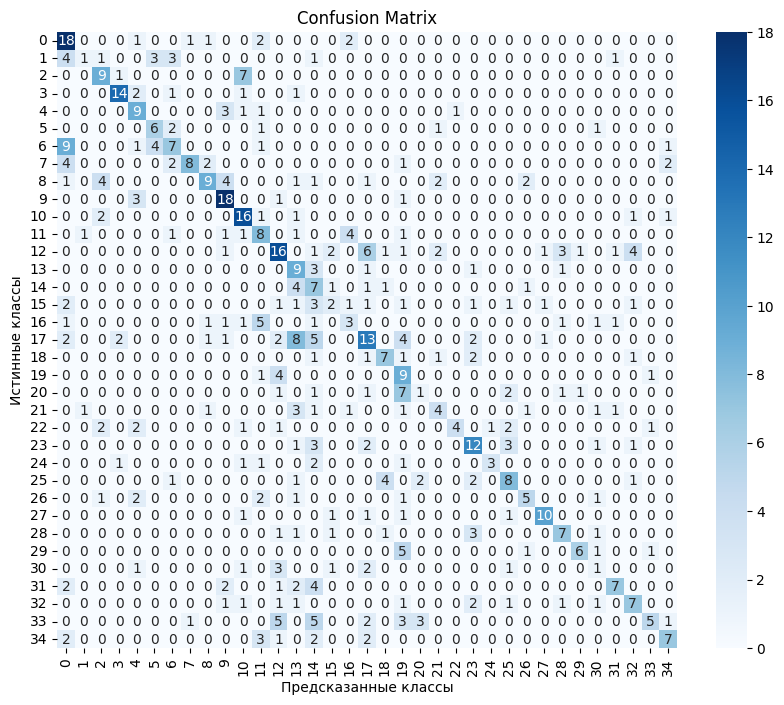

Accuracy: 0.43


In [ ]:
cm = confusion_matrix(y_test, predicted_classes)

# Отображение confusion matrix с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {accuracy_score(y_test, predicted_classes):.2f}")

In [ ]:
# Иной способ провести оценку качества полученной модели
eval_metrics = model.evaluate(X_test, y_test)
print(f"Logloss: {eval_metrics[0]}")
print(f"Accuracy: {eval_metrics[1]}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4213 - loss: 2.0289
Logloss: 2.053459882736206
Accuracy: 0.42990654706954956


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
Порода:
dog_boxer # 15

Предсказанная порода моделью:
dog_beagle # 14


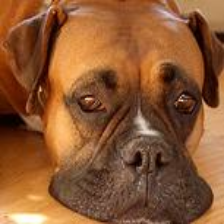

In [ ]:
num = 17                                                             # Рандомный номер
predicted_breed = model.predict(np.expand_dims(X_test[num], axis=0)) # Предсказываем моделью вероятности
predicted_breed = np.argmax(predicted_breed)                         # Вытаскиваем наиболее вероятную породу

print(f"Порода:\n{class_names[y_test[num]]} # {y_test[num]}")                                 # Выведем породу истинную
print(f"\nПредсказанная порода моделью:\n{class_names[predicted_breed]} # {predicted_breed}") # Выведем породу предсказанную
tf.keras.utils.array_to_img(X_test[num])                                                      # Выведем изображение животного

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Порода:
dog_leonberger # 23

Предсказанная порода моделью:
dog_leonberger # 23


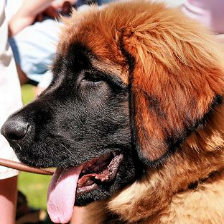

In [ ]:
num = 64                                                             # Рандомный номер
predicted_breed = model.predict(np.expand_dims(X_test[num], axis=0)) # Предсказываем моделью вероятности
predicted_breed = np.argmax(predicted_breed)                         # Вытаскиваем наиболее вероятную породу

print(f"Порода:\n{class_names[y_test[num]]} # {y_test[num]}")                                 # Выведем породу истинную
print(f"\nПредсказанная порода моделью:\n{class_names[predicted_breed]} # {predicted_breed}") # Выведем породу предсказанную
tf.keras.utils.array_to_img(X_test[num])                                                      # Выведем изображение животного

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted class: cat_Abyssinian


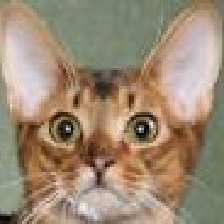

In [ ]:
img_path = "petfaces/cat_Abyssinian/Abyssinian_1.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predicted_breed = model.predict(img_array)
predicted_breed = np.argmax(predicted_breed)

# Название предсказанного класса
print("Predicted class:", class_names[predicted_breed])
img

Чтобы рассчитать метрику top-3 accuracy, нужно:

- Получить вероятности предсказанных классов для каждого изображения
- Выбрать три наиболее вероятных класса для каждого изображения
- Проверить, входит ли истинный класс изображения в топ-3 предсказанных классов
- Рассчитать процент изображений, для которых истинный класс входит в топ-3 предсказанных классов

In [ ]:
probabilities = model.predict(X_test)

top3_predictions = np.argsort(probabilities, axis=1)[:, -3:] # сортировка массива т выбираю топ-3

# Проверка, входит ли истинный класс в топ-3 предсказанных классов для каждого изображения
top3_accuracy = top_k_accuracy_score(y_test, probabilities, k=3)

print("Top-3 Accuracy:", top3_accuracy)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Top-3 Accuracy: 0.6915887850467289


In [31]:
top3_predictions

array([[17, 13, 14],
       [ 3, 10,  9],
       [15, 23, 18],
       ...,
       [ 4, 13, 31],
       [ 6,  1,  8],
       [20, 17, 12]])